In [151]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from ml_logger import ML_Logger, logger
from graph_search import dijkstra
import pandas as pd
import torch
from tqdm import tqdm
from torch_utils import torchify, Eval
from plan2vec_experiments import RUN
from plan2vec_experiments.analysis_icml_2020 import stylize
from plan2vec.models.resnet import *
from plan2vec.plan2vec.streetlearn_plan2vec import Generalization, load_streetlearn, StreetLearnGraph, Args

# Args.env_id = "manhattan-medium"
# Args.r_scale = 2000
# weight_path = "/geyang/plan2vec/2020/04-07/neo_plan2vec/streetlearn/streetlearn_plan2vec/generalization/08.31.44/manhattan-medium-lr(1e-05)-p1.2-ResNet18L2/000/models/05000-Φ.pkl"

Args.env_id = "manhattan-small"
Args.r_scale = 700
weight_path = "/geyang/plan2vec/2020/04-07/neo_plan2vec/streetlearn/streetlearn_plan2vec/generalization/08.41.14/manhattan-small-lr(0.0003)-p1.2-ResNet18L2/sample-True/000/models/02000-Φ.pkl"
weight_path_control = "/geyang/plan2vec/2020/04-07/neo_plan2vec/streetlearn/streetlearn_plan2vec/generalization/08.41.14/manhattan-small-lr(0.0003)-p1.2-ResNet18L2/sample-False/001/models/02000-Φ.pkl"

dataset, start, goal = load_streetlearn(f"~/fair/streetlearn/processed-data/{Args.env_id}")
graph = StreetLearnGraph(dataset, Args.neighbor_r, p=Args.metric_p)
del dataset

add edges: 100%|██████████| 254/254 [00:00<00:00, 15610.49it/s]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/Users/ge/fair/streetlearn/processed-data/manhattan-small/view_512/chunk_0000.npy']
trajectories is loaded!
computing pairwise distance matrix [254 x 254]
✓done


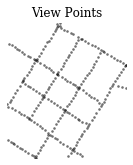

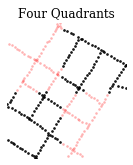

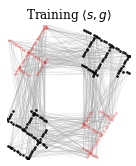

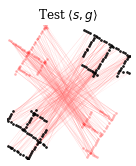

In [148]:
gen = Generalization(graph)
gen.plot()

In [140]:
loader = ML_Logger(log_directory=RUN.server)

Φ = eval(Args.global_metric)(
    Args.input_dim, latent_dim=Args.latent_dim, p=Args.metric_p).to(Args.device)

loader.load_module(Φ, weight_path)

@torchify(dtype=torch.float32)
def d_eval(*_):
    with Eval(Φ), torch.no_grad():
        return Φ(*_)  # .squeeze()

@torchify(dtype=torch.float32)
def embed_eval(*_):
    with Eval(Φ), torch.no_grad():
        return Φ.embed(*_)  # .squeeze()

In [152]:
def compute_labels(specs):
    labels = []
    for s, g in tqdm(specs, desc="computing path length"):
        path, ds = dijkstra(graph, s, g, None)
        labels.append(None if ds is None else np.sum(ds) * Args.r_scale)
    return labels

train_samples = gen.train_sampling(200)
test_samples = gen.test_sampling(200)

result = dict(
    train_labels = compute_labels(train_samples),
    train_y = d_eval(graph.all_images[train_samples[:, 0]], 
                     graph.all_images[train_samples[:, 1]], ),
    test_labels = compute_labels(test_samples),
    test_y = d_eval(graph.all_images[test_samples[:, 0]], 
                     graph.all_images[test_samples[:, 1]], ),
)

computing path length: 100%|██████████| 200/200 [00:00<00:00, 784.44it/s]


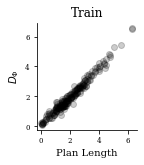

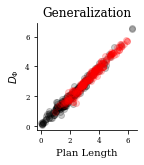

In [154]:
plt.figure(figsize=(2.1, 2.4))
stylize()
plt.title("Train")
plt.scatter(result['train_labels'],result['train_y'], color="black", alpha=0.2)
plt.xlabel('Plan Length')
plt.ylabel('$D_\\Phi$')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
logger.savefig("figures/sl_train_precision.png", dpi=300)
plt.gcf().set_facecolor("white")
plt.show()

plt.figure(figsize=(2.1, 2.4))
stylize()
plt.title("Generalization")
plt.scatter(result['train_labels'],result['train_y'], color="black", alpha=0.2)
plt.scatter(result['test_labels'],result['test_y'], color="red", alpha=0.2)
plt.xlabel('Plan Length')
plt.ylabel('$D_\\Phi$')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
logger.savefig("figures/sl_test_precision.png", dpi=300)
plt.gcf().set_facecolor("white")
plt.show()

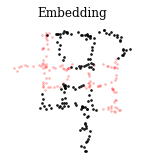

In [155]:
loader.load_module(Φ, weight_path)
zs = embed_eval(graph.all_images)

ll, center, mid, a_inds, b_inds, c_inds, d_inds = gen.quad(graph)

plt.figure(figsize=(2.1, 2.4))
stylize()
plt.title("Embedding")
# plt.scatter(*zs.T, s=3, color='black', alpha=0.4)
plt.scatter(*zs[a_inds].T, s=3, color="black", zorder=100, alpha=0.8)
plt.scatter(*zs[b_inds].T, s=3, color="red", zorder=100, alpha=0.2)
plt.scatter(*zs[c_inds].T, s=3, color="red", zorder=100, alpha=0.2)
plt.scatter(*zs[d_inds].T, s=3, color="black", zorder=100, alpha=0.8)
# plt.gca().set_aspect(graph.lat_correction)
plt.axis('off')
plt.tight_layout()
logger.savefig("figures/sl_embedding.png", dpi=300)
plt.gcf().set_facecolor("white")
plt.show()

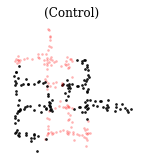

In [147]:
loader.load_module(Φ, weight_path_control)
zs = embed_eval(graph.all_images)

ll, center, mid, a_inds, b_inds, c_inds, d_inds = gen.quad(graph)

plt.figure(figsize=(2.1, 2.4))
stylize()
plt.title("(Control)")
# plt.scatter(*zs.T, s=3, color='black', alpha=0.4)
plt.scatter(*zs[a_inds].T, s=3, color="black", zorder=100, alpha=0.8)
plt.scatter(*zs[b_inds].T, s=3, color="red", zorder=100, alpha=0.2)
plt.scatter(*zs[c_inds].T, s=3, color="red", zorder=100, alpha=0.2)
plt.scatter(*zs[d_inds].T, s=3, color="black", zorder=100, alpha=0.8)
# plt.gca().set_aspect(graph.lat_correction)
plt.axis('off')
plt.tight_layout()
logger.savefig("figures/sl_embedding_control.png", dpi=300)
plt.gcf().set_facecolor("white")
plt.show()